In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision
from PIL import Image
from torch.utils.data.dataset import Dataset

In [2]:
#读取数据
class DatasetFromCSV(Dataset):
    def __init__(self, csv_path, height, width, transforms=None):
        self.csv_path=csv_path
        self.data = pd.read_csv(csv_path)
        self.labels = np.asarray(self.data.iloc[:, 0])
        self.height = height
        self.width = width
        self.transforms = transforms
 
    def __getitem__(self, index):
        single_image_label = self.labels[index]
        # 读取所有像素值，并将 1D array ([784]) reshape 成为 2D array ([28,28])
        if self.csv_path==r"C:/Users/徐昊岩/Desktop/机器学习与深度学习/手写数字识别/train.csv":
            img_as_np = np.asarray(self.data.iloc[index][1:]).reshape(28, 28).astype(float)
        else:img_as_np = np.asarray(self.data.iloc[index][:]).reshape(28, 28).astype(float)
        img_as_img = Image.fromarray(img_as_np)
        img_as_img = img_as_img.convert('L')
        # 将图像转换成 tensor
        if self.transforms is not None:
            img_as_tensor = self.transforms(img_as_img)
            # 返回图像及其 label
        return (img_as_tensor, single_image_label)
 
    def __len__(self):
        return len(self.data.index)

In [3]:
# 定义一个函数，把标签转化为one-hot向量
def label_to_onehot(label):
    # 创建一个零矩阵，大小为(标签数目)x(类别数目)
    onehot = torch.zeros(label.size(0), 10)
    # 根据标签在对应位置填充1
    onehot.scatter_(dim=1,
                    index=label.view(-1, 1),
                    value=1.0)
    return onehot

 
 
batch_size = 512
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,),(0.3081,))])
#把csv文件读取成tensor类型然后转化为dataloader迭代器
train_data= DatasetFromCSV(r"C:/Users/徐昊岩/Desktop/机器学习与深度学习/手写数字识别/train.csv", 28,28,transform)
test_data = DatasetFromCSV(r"C:/Users/徐昊岩/Desktop/机器学习与深度学习/手写数字识别/test.csv",28,28,transform)
 
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=28000)

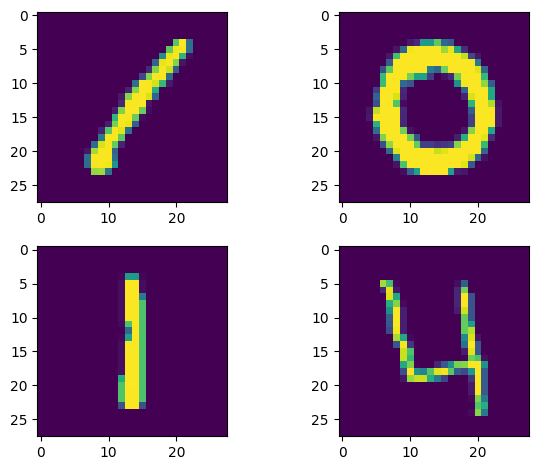

In [4]:
#观察图像
data_train=pd.read_csv(r"C:/Users/徐昊岩/Desktop/机器学习与深度学习/手写数字识别/train.csv")
data_test=pd.read_csv(r"C:/Users/徐昊岩/Desktop/机器学习与深度学习/手写数字识别/test.csv")
for i in range(0,4):
    x=data_train.iloc[i,1:]
    x=np.array(x)
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(x.reshape(28,28))

In [5]:
class Net(nn.Module):
    def __init__(self):
        #继承nn.Module类的初始化属性
        super(Net,self).__init__()
        #设置3层全连接层
        #self.juanji1=nn.Conv2d(1,8,3,padding=1)  #手写数字是单通道，因此只需要一个卷积核
        #self.juanji2=nn.Conv2d(8,16,3,padding=1)
        #self.pool=nn.MaxPool2d(2,2)
        self.fc1=nn.Linear(784,256)   
        self.fc2=nn.Linear(256,64)
        self.fc3=nn.Linear(64,10)
    def forward(self,x):
        #x=self.pool(F.relu(self.juanji1(x)))
        #x=self.pool(F.relu(self.juanji2(x)))
        #x=x.view(-1,64*7*7)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

In [6]:
net=Net()
optimizer=optim.SGD(net.parameters(),lr=0.01,momentum=0.9)#随机梯度下降
train_loss=[]

In [7]:
#独热编码处理标签，方便后续用mse作为误差函数
def one_hot(label,depth=10):
    out=torch.zeros(label.size(0),depth)
    idx=torch.LongTensor(label).view(-1,1)
    out.scatter_(dim=1,index=idx,value=1)
    return out
def plotcurve(data):
    fig=plt.figure()
    plt.plot(range(len(data)),data,color="blue")
    plt.legend(["value"],loc="upper right")
    plt.show()
    

In [10]:
#训练模型
epochs=3
for epoch in range(epochs):
    for batch_size,(x,y) in enumerate(train_loader):
        x=x.view(x.size(0),28*28)
        #torch.nn.functional.one_hot(targets)
        out=net(x)
        y_onehot=one_hot(y)
        #均方差损失函数及优化过程
        loss=F.mse_loss(out,y_onehot)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

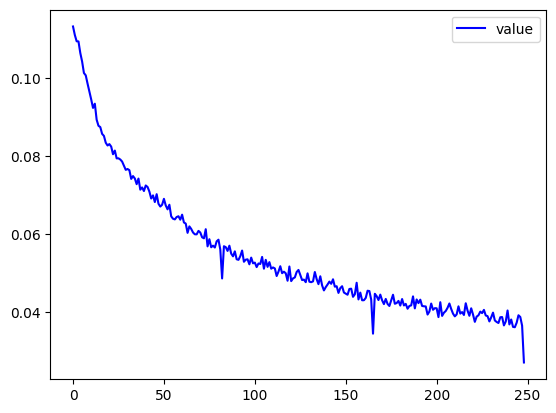

In [11]:
plotcurve(train_loss)

In [13]:
for x,y in test_loader:
    z=x.view(x.size(0),784)
    out=net(z)
    pred=out.argmax(dim=1)
    a = pd.DataFrame(pred.detach())
    a.to_csv(path_or_buf="C:/Users/徐昊岩/Desktop/机器学习与深度学习/手写数字识别/fin.csv",index=False)

In [14]:
def plot_image(img,label,name):
    fig=plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(img[i][0]*0.3081+0.1307)
        plt.title("{}:{}".format(name,label[i].item()))
    plt.show
        

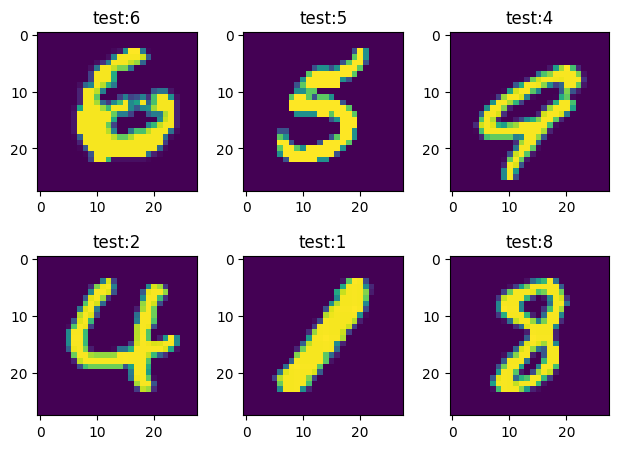

In [15]:
plot_image(x[500:510],pred[500:510],"test")